In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
import torchvision, torchvision.transforms
import cv2
import numpy

import os
import numpy as np
from PIL import Image
from math import ceil,floor

import matplotlib.pyplot as plt
%matplotlib inline

dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

In [16]:
from Generator import Generator, ResiduleBlock

In [57]:
video_dir = r'D:\ml\Diploma\ConvertNetProcess\from'
#generator_weights_dir = r'D:\ml\Diploma\ConvertNetProcess\net_weights_20201108-best'
#generator_weights_F = os.path.join(generator_weights_dir, 'F_tmp.pt')
#generator_weights_G = os.path.join(generator_weights_dir, 'G_tmp.pt')

loadOnlyWeights, generator_dir = True,  r'D:\ml\Diploma\ConvertNetProcess\6_weights'
loadOnlyWeights, generator_dir = True,  r'D:\ml\Diploma\ConvertNetProcess\8_weights'
loadOnlyWeights, generator_dir = False, r'D:\ml\Diploma\ConvertNetProcess\10_net'
loadOnlyWeights, generator_dir = False, r'D:\ml\Diploma\ConvertNetProcess\14-3_net'


if loadOnlyWeights:
    Generator_G = Generator(12).type(torch.cuda.FloatTensor)
    Generator_F = Generator(12).type(torch.cuda.FloatTensor)
    Generator_G.load_state_dict(torch.load(os.path.join(generator_dir,"G_tmp.pt")))
    Generator_F.load_state_dict(torch.load(os.path.join(generator_dir,"G_tmp.pt")))
else:
    generator_F_path = os.path.join(generator_dir, 'F.pt')
    generator_G_path = os.path.join(generator_dir, 'G.pt')
    Generator_G = torch.load(generator_G_path).type(dtype)
    Generator_F = torch.load(generator_F_path).type(dtype)

video_from = os.path.join(video_dir, 'youtube_gta5.mp4')
video_to_F = os.path.join(video_dir, 'youtube_gta5-14-3_F.mp4')
video_to_G = os.path.join(video_dir, 'youtube_gta5-14-3_G.mp4')

from_sec = 715
to_sec   = 800

flip_horizontal = False
make_brighter = False

#def get_file_list(dir):
#  return [os.path.join(dir, i) for i in os.listdir(dir)]



In [58]:
# создаем Custom Dataset под нашу задачу - возвращаем картинку, преобразованную с помощью заданного transform
class ImgCustomDataset(Dataset):
    def __init__(self, video_from: str, from_sec, to_sec, transform = None):
        self.video_from = video_from
        self.transform = transform
        
        self.vidcap=cv2.VideoCapture(self.video_from)
        self.from_sec = from_sec
        self.to_sec = to_sec
        """
        vidcap.set(cv2.CAP_PROP_POS_AVI_RATIO, 1)
        length = vidcap.get(cv2.CAP_PROP_POS_MSEC)
        print(f'{self.video_from} length {length}')
        self.count = floor(length*0.1)
        """
        self.frameRate = 0.1 #//it will capture image in each 0.1 second
        self.SetCount()

    def SetCount(self):
        self.count = 60*1000*1000 # break on file finished and catch exception as code below is very slow
        return
    
        count = 0
        while True:
            sec = count * self.frameRate
            sec = round(sec, 2)
            print(sec)
            self.vidcap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
            hasFrames, image = self.vidcap.read()
            if not hasFrames:
                break
            count += 1
        self.count = count
        
    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        assert isinstance(idx, int), "ImgCustomDataset: idx is not an integer: %r" % idx
        sec = self.from_sec + idx * self.frameRate
        sec = round(sec, 2)
        self.vidcap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
        hasFrames, image = self.vidcap.read()
        if (not hasFrames) or (sec > self.to_sec):
            raise Exception('not hasFrames')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        global flip_horizontal
        if flip_horizontal:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        
        self.count = self.count + 1
        if self.transform:
            image = self.transform(image)
        
        global make_brighter
        if make_brighter:
            image = torchvision.transforms.functional.adjust_contrast(image, 0.7)
            image = torchvision.transforms.functional.adjust_brightness(image, brightness_factor = 1.5)
        return image
    
    
class Resize2Min(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))
        assert len(output_size) == 2
        self.output_size = output_size

    def __call__(self, image):
        ratio0 = image.size[0]/self.output_size[1]
        ratio1 = image.size[1]/self.output_size[0]
        ratio = min(ratio0, ratio1)
        #print(image.size)
        #print(ratio)
        new_size = (ceil(image.size[0]/ratio), ceil(image.size[1]/ratio))
        #print(new_size)
        return image.resize(new_size)
        
    
def get_transform_simple(target_size = (272, 480)):
    return torchvision.transforms.Compose([
        #Resize2Min(target_size),
        torchvision.transforms.CenterCrop(target_size),
        # torchvision.transforms.CenterCrop(218),   # добавим черного фона по краям до квадрата
        # torchvision.transforms.Resize(target_size),
        torchvision.transforms.ToTensor(),
    ])



In [59]:
target_video_size = (272, 480)
simple_transform = get_transform_simple(target_video_size)
imagesDataset = ImgCustomDataset(video_from, from_sec, to_sec, transform = simple_transform)

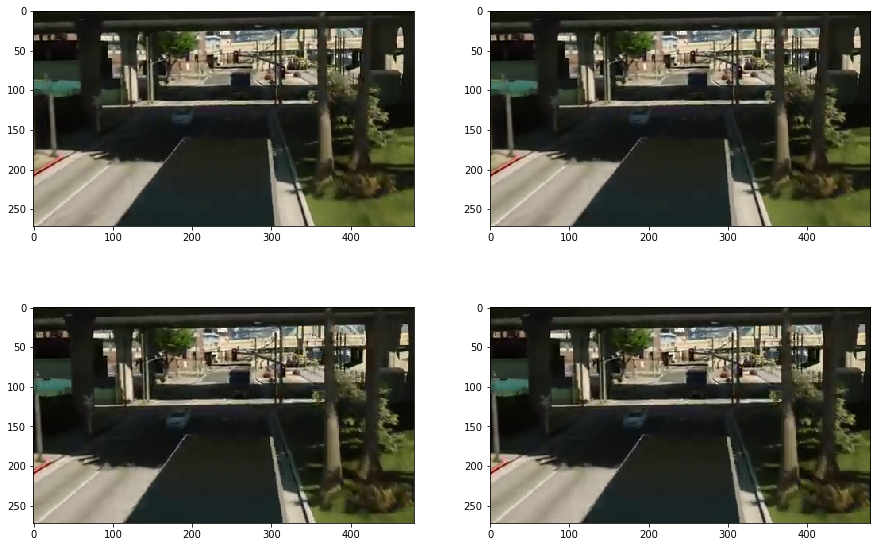

In [60]:
def show_dataset(dataset, n=2):
  images = []
  K = 2
  fig, ax = plt.subplots(K, n, figsize=(15,10))
  for i in range(K):
    for j in range(n):
      images.append(dataset[32+i])
      ax[i,j].imshow(dataset[32+i].permute(1, 2, 0))
  
  #plt.imshow(torchvision.utils.make_grid(images, nrow=n).permute(1, 2, 0))
  
  plt.show()

#print(imagesDataset[0])
show_dataset(imagesDataset)

In [61]:
batch_size=64                  #  64
transformerToPil = torchvision.transforms.ToPILImage()
dataloader = torch.utils.data.DataLoader(imagesDataset, batch_size=batch_size, shuffle=False) 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device {device}')

Generator_F = Generator_F.type(dtype)
Generator_G = Generator_G.type(dtype)

#model = model.to(device)
Generator_F.eval()
Generator_G.eval()
i = 0

size = (target_video_size[1],target_video_size[0])
out_F = cv2.VideoWriter(video_to_F, cv2.VideoWriter_fourcc(*'DIVX'), 1/imagesDataset.frameRate, size)
out_G = cv2.VideoWriter(video_to_G, cv2.VideoWriter_fourcc(*'DIVX'), 1/imagesDataset.frameRate, size)
print(imagesDataset.frameRate)
print(size)

def add_to_video(out, outputs):
    for img in outputs:
        pil_image = transformerToPil(img) #.convert("RGB")
        #open_cv_image = numpy.array(pil_image) 
        # Convert RGB to BGR 
        opencvImage = cv2.cvtColor(numpy.array(pil_image), cv2.COLOR_RGB2BGR)
        out.write(opencvImage)
        #cv2.imwrite(rf'D:\ml\Diploma\ConvertNetProcess\{i}.jpg', opencvImage)
            
try:
    for banch_n, inputs in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs_F = Generator_F(inputs)
            outputs_G = Generator_G(inputs)
        outputs_F = outputs_F.to('cpu')
        outputs_G = outputs_G.to('cpu')
        print(f'{banch_n}')
        add_to_video(out_G, outputs_G)
        add_to_video(out_F, outputs_F)
        i += 1
except Exception as e:
    s = str(e)
    print(f'End: {s}')
    pass

out_F.release()
out_G.release()

del Generator_F
del Generator_G
del inputs
torch.cuda.empty_cache()

device cuda
0.1
(480, 272)
0
1
2
3
4
5
6
7
8
9
10
11
12
End: not hasFrames
